## Importing python packages

In [1]:
import numpy as np
import cv2
import glob, time, pickle
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

## Reading Training dataset

In [3]:
car_imgs = glob.glob('training_ds/vehicles/**/*.png')
noncar_imgs = glob.glob('training_ds/non-vehicles/**/*.png')


print("No.Of. Car Imgs:", len(car_imgs))
print("No.Of. non Car Imgs:", len(noncar_imgs))

No.Of. Car Imgs: 8792
No.Of. non Car Imgs: 8968


## Visualizing few Training samples

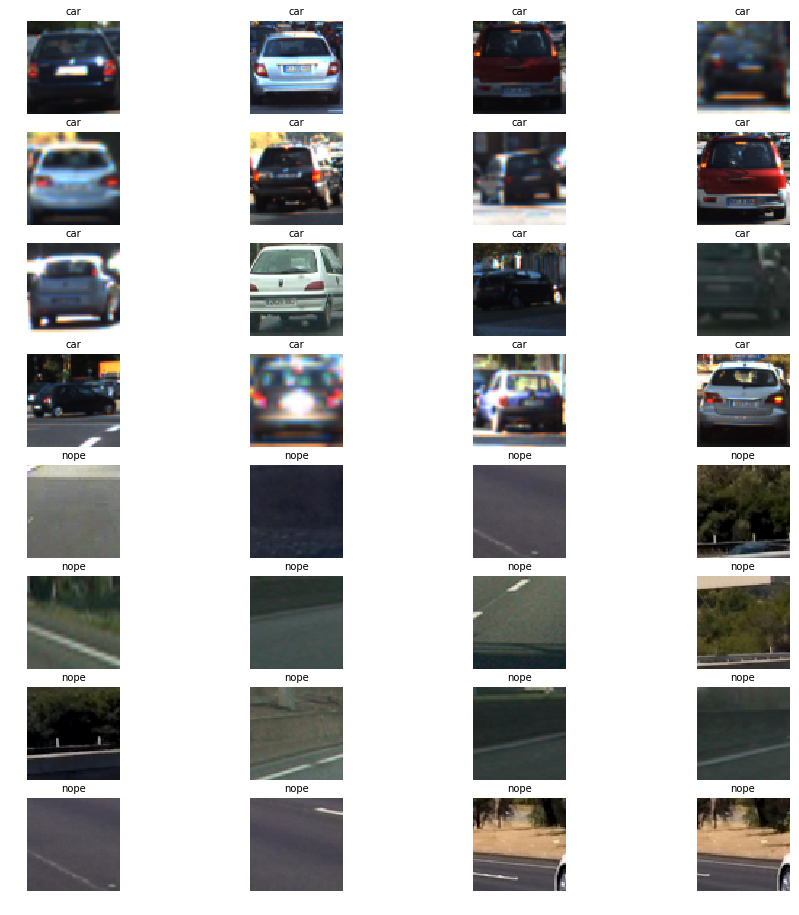

In [14]:
fig, axs = plt.subplots(8,4, figsize=(16, 16))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# imshow of random car images 
for i in np.arange(16):
    img = cv2.imread(car_imgs[np.random.randint(0,len(car_imgs))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('car', fontsize=10)
    axs[i].imshow(img)
    
# imshow of random non vehcile images
for i in np.arange(16,32):
    img = cv2.imread(noncar_imgs[np.random.randint(0,len(noncar_imgs))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('nope', fontsize=10)
    axs[i].imshow(img)

## Method to transform input image to HOG (Histogram of Oriented Gradinets) image

In [68]:
def extract_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

## Visulaizing HOG image

Text(0.5,1,'Non-Car HOG Features')

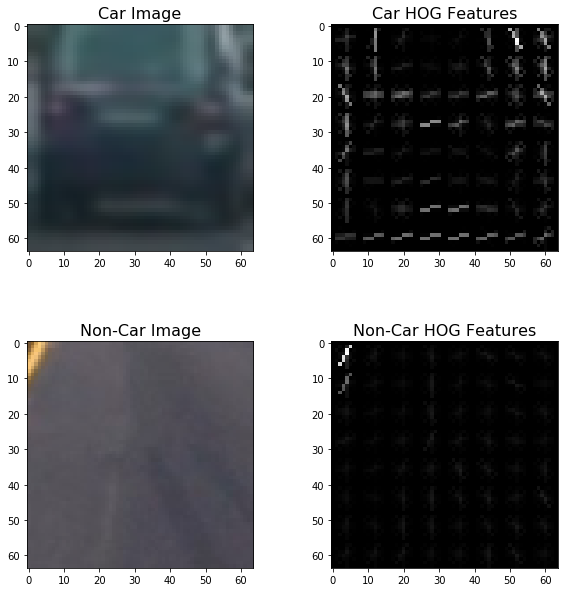

In [69]:
# Reading one car and one non-car sample images (Ex: idx - 12)
car_img = mpimg.imread(car_imgs[12])
_, car_dst = extract_hog_features(car_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
noncar_img = mpimg.imread(noncar_imgs[12])
_, noncar_dst = extract_hog_features(noncar_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

# Visualize HOG images
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car_img)
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(car_dst, cmap='gray')
ax2.set_title('Car HOG Features', fontsize=16)
ax3.imshow(noncar_img)
ax3.set_title('Non-Car Image', fontsize=16)
ax4.imshow(noncar_dst, cmap='gray')
ax4.set_title('Non-Car HOG Features', fontsize=16)


## Extracting HOG features from Array of images

In [77]:
# Function to extract features from a list of image locations

def hog_features(imgs, color_space='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_ch=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Calling hog_features_list() with vis=False, feature_vec=True
        if hog_ch == 'ALL':
            hog_ftrs = []
            for channel in range(feature_image.shape[2]):
                hog_ftrs.append(extract_hog_features(feature_image[:,:,channel], orient, pix_per_cell, cell_per_block,
                                                      vis=False, feature_vec=True))
            hog_ftrs = np.ravel(hog_ftrs)
        else:
            hog_ftrs = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        # Append every new hog_ftrs to features list
        features.append(hog_ftrs)
                                
    # Return list of feature vectors
    return features

## Extracting input data set features

In [71]:


# Can be RGB, HSV, LUV, HLS, YUV, YCrCb
colorspace = 'YUV' 
orient = 11
pix_per_cell = 16
cell_per_block = 2

 # Can be 0, 1, 2, or "ALL"
hog_channel = 'ALL'

car_features = hog_features(car_imgs, color_space=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_ch=hog_channel)

noncar_features = hog_features(noncar_imgs, color_space=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_ch=hog_channel)

# Create an array stack of hog feature vectors
X = np.vstack((car_features, noncar_features)).astype(np.float64)  


## Labeling input image HOG feature sets

In [72]:

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))


## Train and Test sample randmo split

In [73]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

print('Feature vector length:', len(X_train[0]))

Feature vector length: 1188


## Train a Classifier

In [74]:
# Use a linear SVC 
svc = LinearSVC()
# Training time for the SVC
t0 = time.time()
svc.fit(X_train, y_train)
t1 = time.time()
print(round(t1-t0, 2), 'Secs to train SVC...')

# Score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t0=time.time()
n_predict = 10
print('SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t1 = time.time()
print(round(t1-t0, 5), 'Seconds to predict', n_predict,'labels with SVC')

2.37 Secs to train SVC...
Test Accuracy of SVC =  0.9828
SVC predicts:  [1. 0. 1. 0. 1. 0. 0. 1. 0. 1.]
For these 10 labels:  [1. 0. 1. 0. 1. 0. 0. 1. 0. 1.]
0.01071 Seconds to predict 10 labels with SVC


## Detecting Cars Using trained Classifier 

In [119]:
# Function that extracts features using hog sub-sampling and make predictions
def detect_cars(img, ystart, ystop, scale, color_space, hog_ch, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False):
    
    # array of rectangles where cars were detected
    rects = []
    
    img = img.astype(np.float32)/255
    
    img_area_to_look = img[ystart:ystop,:,:]

    # apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            ct_to_look = cv2.cvtColor(img_area_to_look, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            ct_to_look = cv2.cvtColor(img_area_to_look, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            ct_to_look = cv2.cvtColor(img_area_to_look, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            ct_to_look = cv2.cvtColor(img_area_to_look, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            ct_to_look = cv2.cvtColor(img_area_to_look, cv2.COLOR_RGB2YCrCb)
    else: ct_to_look = np.copy(img)   
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ct_to_look.shape
        ct_to_look = cv2.resize(ct_to_look, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ct_to_look[:,:,0]
        ch2 = ct_to_look[:,:,1]
        ch3 = ct_to_look[:,:,2]
    else: 
        ch1 = ct_to_look[:,:,hog_ch]

    # Define blocks and steps as above
    nx_blocks = (ch1.shape[1] // pix_per_cell)+1  
    ny_blocks = (ch1.shape[0] // pix_per_cell)+1  

    
    # SR = 64, with 8 cells and 8 pix per cell
    sr = 64
    nblks_per_window = (sr // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nx_steps = (nx_blocks - nblks_per_window) // cells_per_step
    ny_steps = (ny_blocks - nblks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = extract_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    if hog_ch == 'ALL':
        hog2 = extract_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = extract_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nx_steps):
        for yb in range(ny_steps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_f1 = hog1[ypos:ypos + nblks_per_window, xpos:xpos + nblks_per_window].ravel()
            if hog_ch == 'ALL':
                hog_f2 = hog2[ypos:ypos+nblks_per_window, xpos:xpos+nblks_per_window].ravel() 
                hog_f3 = hog3[ypos:ypos+nblks_per_window, xpos:xpos+nblks_per_window].ravel() 
                hog_ftrs = np.hstack((hog_f1, hog_f2, hog_f3))
            else:
                hog_ftrs = hog_f1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            hog_ftrs = hog_ftrs.reshape(1, -1)
            test_prediction = svc.predict(hog_ftrs)
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                draw = np.int(sr*scale)
                rects.append(((xbox_left, ytop_draw+ystart),(xbox_left + draw,ytop_draw + draw + ystart)))

    return rects

## Sample classification on test image for Cars

In [120]:
test_img = mpimg.imread('./test_images/test1.jpg')

ystart = 400
ystop = 656
scale = 1.5
colorspace = 'YUV'
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_ch = 'ALL'

rectangles = detect_cars(test_img, ystart, ystop, scale, colorspace, hog_ch, svc, None, orient, pix_per_cell, cell_per_block, None, None)

print(len(rectangles), 'rectangles found in image')

4 rectangles found in image


## Drawing bounding box on detected objects (Car) in a given image

In [129]:
# Here is your draw_boxes function from the previous exercise
def draw_bbox(img, bboxes, color=(0, 0, 255), thick=5):
    
    # Copy of ip image
    imcopy = np.copy(img)
    random_color = False

    # Run through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
            
        # Draw a rectangle using opencv cv2.rectangle with bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    
    return imcopy


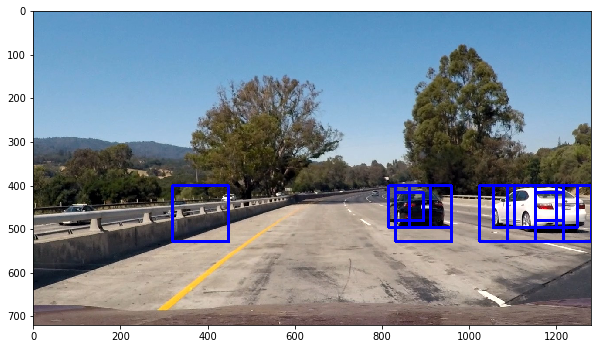

In [130]:
test_img_rects = draw_bbox(test_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)


## Calling detect cars using different window size

Number of boxes:  50


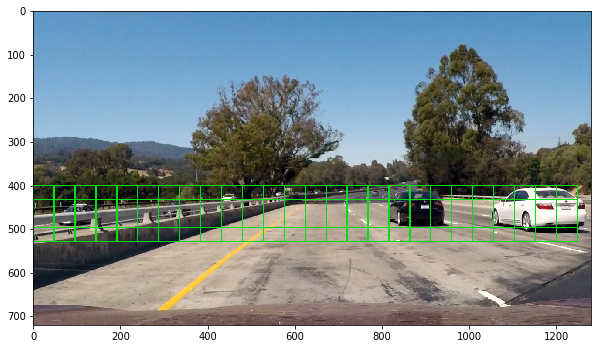

In [131]:
test_img = mpimg.imread('./test_images/test1.jpg')

rects = []

ystart = 400
ystop = 496
scale = 1.5
rects.append(detect_cars(test_img, ystart, ystop, scale, colorspace, hog_ch, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))
ystart = 432
ystop = 528
scale = 1.5
rects.append(detect_cars(test_img, ystart, ystop, scale, colorspace, hog_ch, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_bbox(test_img, rectangles, color=(0,222,22), thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))


## Combining Various Sliding Windows

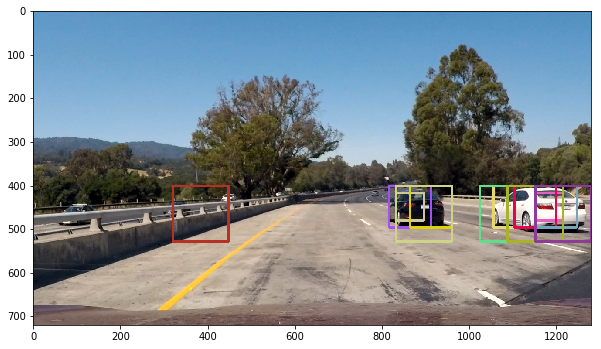

In [134]:
test_img = mpimg.imread('./test_images/test1.jpg')

rectangles = []

color_space = 'YUV' 
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_ch = 'ALL' 


ystart = 400
ystop = 464
scale = 1.0
rectangles.append(detect_cars(test_img, ystart, ystop, scale, color_space, hog_ch, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 416
ystop = 480
scale = 1.0
rectangles.append(detect_cars(test_img, ystart, ystop, scale, color_space, hog_ch, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 400
ystop = 496
scale = 1.5
rectangles.append(detect_cars(test_img, ystart, ystop, scale, color_space, hog_ch, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 432
ystop = 528
scale = 1.5
rectangles.append(detect_cars(test_img, ystart, ystop, scale, color_space, hog_ch, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 400
ystop = 528
scale = 2.0
rectangles.append(detect_cars(test_img, ystart, ystop, scale, color_space, hog_ch, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 432
ystop = 560
scale = 2.0
rectangles.append(detect_cars(test_img, ystart, ystop, scale, color_space, hog_ch, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 400
ystop = 596
scale = 3.5
rectangles.append(detect_cars(test_img, ystart, ystop, scale, color_space, hog_ch, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 464
ystop = 660
scale = 3.5
rectangles.append(detect_cars(test_img, ystart, ystop, scale, color_space, hog_ch, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))

# apparently this is the best way to flatten a list of lists
rectangles = [item for sublist in rectangles for item in sublist] 
test_img_rects = draw_bbox(test_img, rectangles, color='random', thick=3)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)


## HearMap

In [140]:
def heat_map(heatmap, bb_list):
    
    for box in bb_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap


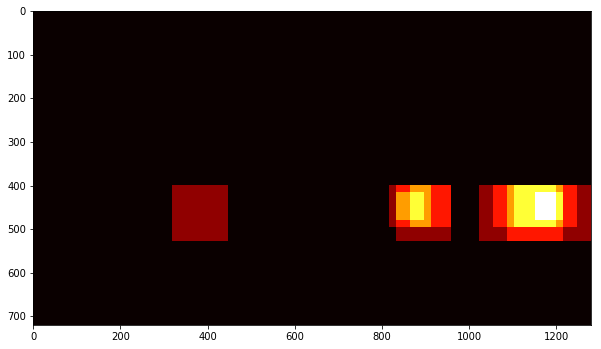

In [141]:
# Test out the heatmap
heat_map_img = np.zeros_like(test_img[:,:,0])
heat_map_img = heat_map(heat_map_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(heat_map_img, cmap='hot')



## Apply Threshold to Hear Map

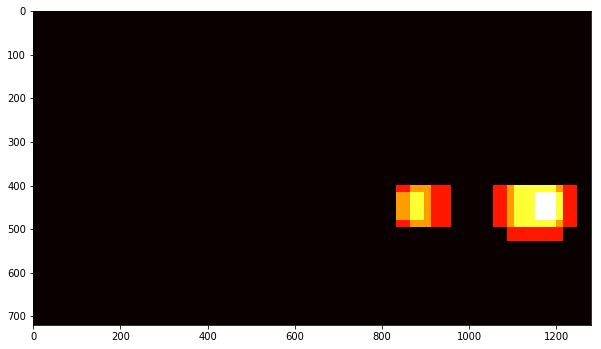

In [142]:
def apply_thr(heatmap, threshold):
    
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    
    return heatmap

heat_map_img = apply_thr(heat_map_img, 1)
plt.figure(figsize=(10,10))
plt.imshow(heat_map_img, cmap='hot')


## Apply SciPy labels

2 cars found


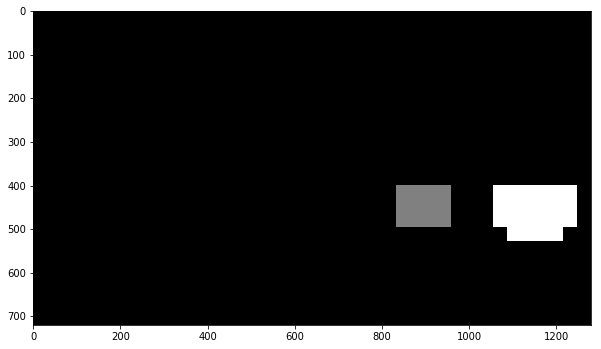

In [143]:
labels = label(heat_map_img)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')

# Draw BB for labesl extracted

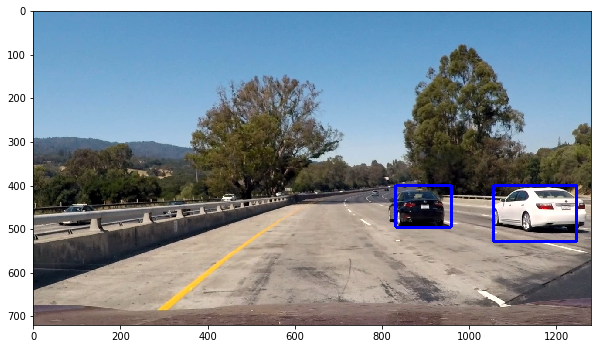

In [145]:
def draw_bboxes_for_labeled(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        non_zero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(non_zero[0])
        nonzerox = np.array(non_zero[1])
        # Define a bounding box based on min/max of x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

# Draw bounding boxes on a copy of the image
draw_img, rect = draw_bboxes_for_labeled(np.copy(test_img), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)


## Building pipeline

In [146]:
def process_frame(img):

    rectangles = []

    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

    ystart = 400
    ystop = 464
    scale = 1.0
    rectangles.append(detect_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 416
    ystop = 480
    scale = 1.0
    rectangles.append(detect_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 496
    scale = 1.5
    rectangles.append(detect_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 432
    ystop = 528
    scale = 1.5
    rectangles.append(detect_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 528
    scale = 2.0
    rectangles.append(detect_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 432
    ystop = 560
    scale = 2.0
    rectangles.append(detect_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 596
    scale = 3.5
    rectangles.append(detect_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 464
    ystop = 660
    scale = 3.5
    rectangles.append(detect_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    rectangles = [item for sublist in rectangles for item in sublist] 
    
    heat_map_img = np.zeros_like(img[:,:,0])
    heat_map_img = heat_map(heat_map_img, rectangles)
    heat_map_img = apply_thr(heat_map_img, 1)
    labels = label(heat_map_img)
    draw_img, rects = draw_bboxes_for_labeled(np.copy(img), labels)
    return draw_img


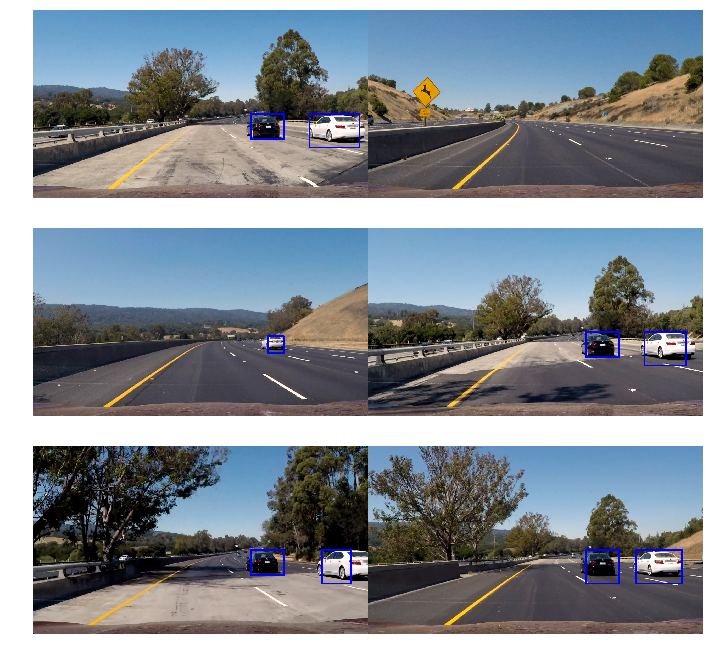

In [148]:
test_imgs = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(12,12))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_imgs):
    axs[i].imshow(process_frame(mpimg.imread(im)))
    axs[i].axis('off')


# Run Video Through pipeline

In [149]:
test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(process_frame)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|████████████████████████████████████████████████████████████████▎ | 38/39 [00:18<00:00,  1.91it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

Wall time: 19.9 s


In [150]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file))

## Class to store Vehcile Detection

In [152]:
# Define a class to store data from video
class VehicleDetect():
    def __init__(self):
        # rectangles from previous n frames
        self.prev_rects = [] 
        
    def add_rects(self, rects):
        self.prev_rects.append(rects)
        if len(self.prev_rects) > 15:
            # Oldest rectangle set(s)
            self.prev_rects = self.prev_rects[len(self.prev_rects)-15:]


## Pipeline for processing Videos

In [156]:
def process_frame_for_video(img):

    rectangles = []

    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    
    ystart = 400
    ystop = 464
    scale = 1.0
    rectangles.append(detect_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 416
    ystop = 480
    scale = 1.0
    rectangles.append(detect_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 496
    scale = 1.5
    rectangles.append(detect_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 432
    ystop = 528
    scale = 1.5
    rectangles.append(detect_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 528
    scale = 2.0
    rectangles.append(detect_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 432
    ystop = 560
    scale = 2.0
    rectangles.append(detect_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 596
    scale = 3.5
    rectangles.append(detect_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 464
    ystop = 660
    scale = 3.5
    rectangles.append(detect_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
 
    rectangles = [item for sublist in rectangles for item in sublist] 
    
    # add detections to the history
    if len(rectangles) > 0:
        det.add_rects(rectangles)
    
    heat_map_img = np.zeros_like(img[:,:,0])
    for rect_set in det.prev_rects:
        heat_map_img = heat_map(heat_map_img, rect_set)
    heat_map_img = apply_thr(heat_map_img, 1 + len(det.prev_rects)//2)
     
    labels = label(heat_map_img)
    draw_img, rect = draw_bboxes_for_labeled(np.copy(img), labels)
    return draw_img


## Run Video sample to Pipeline

In [157]:
det = VehicleDetect()

test_out_file2 = 'test_video_out_2.mp4'
clip_test2 = VideoFileClip('test_video.mp4')
clip_test_out2 = clip_test2.fl_image(process_frame_for_video)
%time clip_test_out2.write_videofile(test_out_file2, audio=False)

[MoviePy] >>>> Building video test_video_out_2.mp4
[MoviePy] Writing video test_video_out_2.mp4


 97%|████████████████████████████████████████████████████████████████▎ | 38/39 [00:20<00:00,  1.85it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out_2.mp4 

Wall time: 21.4 s


In [158]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file2))

## Project Video through pipeline

In [159]:
det = VehicleDetect()

proj_out_file = 'project_video_out.mp4'
clip_proj = VideoFileClip('project_video.mp4') 

clip_proj_out = clip_proj.fl_image(process_frame_for_video)
%time clip_proj_out.write_videofile(proj_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████████████████████████████████████████████████████████▉| 1260/1261 [11:47<00:00,  1.99it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Wall time: 11min 48s


In [160]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(proj_out_file))